**2277007 김수진 2277021 오유진**

### MNIST 필기체 숫자 인식 코드
### Sequential, Functional,  Model Subclassing으로 코딩하기

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.10.0
2.10.0


In [2]:
learning_rate = 0.001
epochs = 15
#training_epochs = 15
batch_size = 100

tf.random.set_seed(777)

In [3]:
#mnist 데이터
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [4]:
#Datasets
(X_train, y_train), (X_test, y_test) = mnist.load_data()    

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

print(X_train.shape, X_test.shape) #3차원 데이터

(60000, 28, 28) (10000, 28, 28)


In [5]:
#CNN 입력값은 4차원이여야 하므로 차원을 하나 추가함
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

#Y 데이터 원-핫 인코딩(0,1로만 표현하고자함)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)   

In [6]:
#훈련데이터 batch_size 만큼 잘라서 shuffle해서 데이터셋에 넣음
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(
                buffer_size=100000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# 1. Sequential

순차적 학습을 하는 모델링(레이어를 하나하나씩 추가해야함)

Sequential API allows you to create models layer-by-layer by stacking them. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

fully-connected layer = 두 단    
convolution =  3x3  
stride= 1  
padding = same  
max pooling = 2x2,   
strid e= 2,  
padding = same  

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

In [8]:
#define a function
def create_model():
    model = Sequential() 
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME', 
                                  input_shape=(28, 28, 1))) #X_train.shape = (60000, 28, 28)이므로 input_shape=(28,28)
    model.add(keras.layers.MaxPool2D(padding='SAME')) #디폴트가 padding='VALID'이므로 변경
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    
    model.add(keras.layers.Flatten()) #feature map을 벡터를 펴주는 작업으로하기위해 Flatten사용
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4)) #convolution에비해 파라미터가 많아서 Dropout 사용
    model.add(keras.layers.Dense(10))
    return model

In [9]:
model = create_model() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

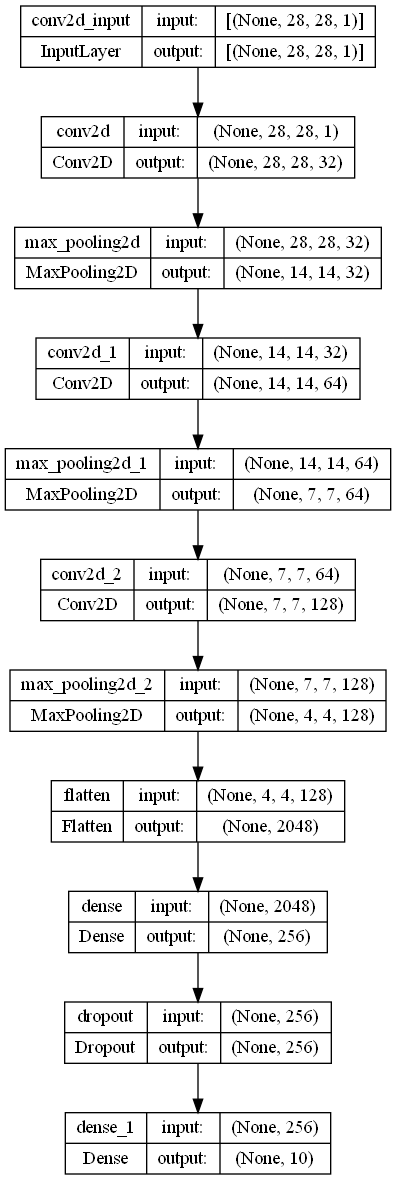

In [10]:
model.summary() 
tf.keras.utils.plot_model(model, "myModel.png", show_shapes=True)

In [12]:
#Loss Function
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))     
    return loss   

# Calculating Gradient
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

# Caculating Model's Accuracy
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

# select a optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#Training
def train(model, images, labels):
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

#이중 for문으로 학습
for epoch in range(epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model, images, labels)
        #grads = grad(model, images, labels)                
        #optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    #test_set으로 evaluate하자.
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))

Epoch: 1 loss = 0.06398869 train accuracy =  0.9865 test accuracy =  0.9900
Epoch: 2 loss = 0.03537028 train accuracy =  0.9927 test accuracy =  0.9925
Epoch: 3 loss = 0.02522959 train accuracy =  0.9950 test accuracy =  0.9935
Epoch: 4 loss = 0.01897597 train accuracy =  0.9963 test accuracy =  0.9918
Epoch: 5 loss = 0.01505488 train accuracy =  0.9973 test accuracy =  0.9924
Epoch: 6 loss = 0.01291355 train accuracy =  0.9979 test accuracy =  0.9929
Epoch: 7 loss = 0.01052132 train accuracy =  0.9983 test accuracy =  0.9924
Epoch: 8 loss = 0.00797717 train accuracy =  0.9988 test accuracy =  0.9923
Epoch: 9 loss = 0.00731937 train accuracy =  0.9989 test accuracy =  0.9931
Epoch: 10 loss = 0.00607583 train accuracy =  0.9992 test accuracy =  0.9926
Epoch: 11 loss = 0.00542428 train accuracy =  0.9994 test accuracy =  0.9919
Epoch: 12 loss = 0.00587102 train accuracy =  0.9993 test accuracy =  0.9934
Epoch: 13 loss = 0.00492342 train accuracy =  0.9994 test accuracy =  0.9952
Epoch: 1

# 2. Functional

- Sequential 방식과의 차별점 = inception, residual connections **돌아와 덧셈**하도록 구현 가능    
- 코드에서 따로 레이어를 명시해야함.

Keras functional API provides a more flexibility as you can easily defines models where layers connect to more than just the previous and next layers, and you can connect layers to any other layers. As a result, you can create complex network such as Residual Network.

In [13]:
#define function
def create_model():
    inputs = keras.Input(shape=(28, 28, 1))
    # ()=레이어에서 사용할 입력 레이어
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(inputs)
    pool1 = keras.layers.MaxPool2D(padding='SAME')(conv1) #conv1 layer들어감
    
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME',
                                activation=tf.nn.relu)(pool1)  #pool1 layer들어감
    pool2 = keras.layers.MaxPool2D(padding='SAME')(conv2)
    
    conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool2)
    pool3 = keras.layers.MaxPool2D(padding='SAME')(conv3)
    pool3_flat = keras.layers.Flatten()(pool3)
    
    dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)(pool3_flat)
    drop4 = keras.layers.Dropout(rate=0.4)(dense4)
    logits = keras.layers.Dense(units=10)(drop4)
    return keras.Model(inputs=inputs, outputs=logits)

In [14]:
model = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856 

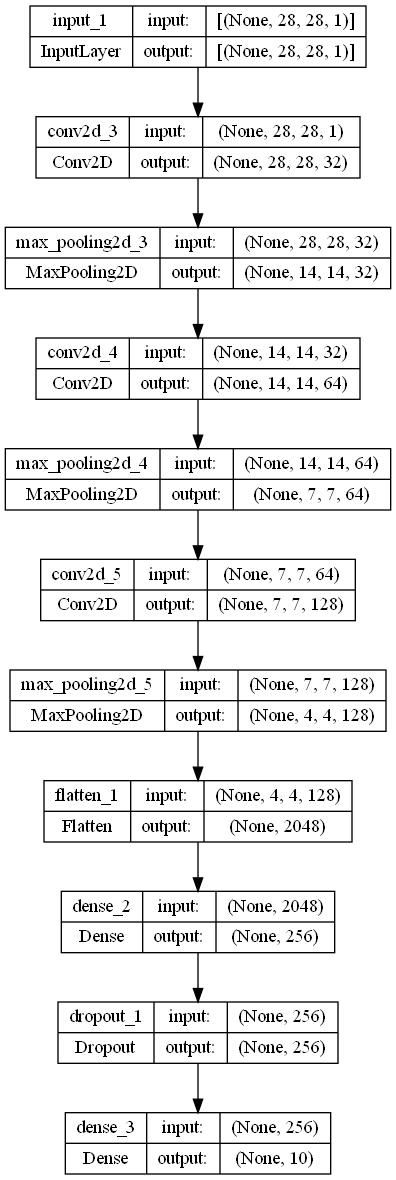

In [15]:
model.summary()
tf.keras.utils.plot_model(model, "myModel.png", show_shapes=True)

In [16]:
#Loss Function
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))     
    return loss   

# Calculating Gradient
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

# Caculating Model's Accuracy
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

# select a optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#Training
def train(model, images, labels):
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

#이중 for문으로 학습
for epoch in range(epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model, images, labels)
        #grads = grad(model, images, labels)                
        #optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    #test_set으로 evaluate하자.
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))

Epoch: 1 loss = 0.17879005 train accuracy =  0.9569 test accuracy =  0.9869
Epoch: 2 loss = 0.04589628 train accuracy =  0.9898 test accuracy =  0.9918
Epoch: 3 loss = 0.03174786 train accuracy =  0.9933 test accuracy =  0.9919
Epoch: 4 loss = 0.02234513 train accuracy =  0.9955 test accuracy =  0.9905
Epoch: 5 loss = 0.01783769 train accuracy =  0.9968 test accuracy =  0.9907
Epoch: 6 loss = 0.01486329 train accuracy =  0.9972 test accuracy =  0.9931
Epoch: 7 loss = 0.01153251 train accuracy =  0.9980 test accuracy =  0.9931
Epoch: 8 loss = 0.01128532 train accuracy =  0.9981 test accuracy =  0.9931
Epoch: 9 loss = 0.00913853 train accuracy =  0.9989 test accuracy =  0.9911
Epoch: 10 loss = 0.00802765 train accuracy =  0.9988 test accuracy =  0.9927
Epoch: 11 loss = 0.00673225 train accuracy =  0.9991 test accuracy =  0.9932
Epoch: 12 loss = 0.00547430 train accuracy =  0.9994 test accuracy =  0.9921
Epoch: 13 loss = 0.00557624 train accuracy =  0.9993 test accuracy =  0.9937
Epoch: 1

# 3. Model Subclassing

- operation등을 자유롭게 추가 가능
- Create layers in init method -> call method
- ensemble 방법 사용이 쉬워짐

If you are familiar with Object Oriented Programming (OOP), then this method is the most efficient way. By subclassing the Model class: in that case, you should define your layers in __init__ and you should implement the model's forward pass in call.

In [17]:
class MNISTModel(tf.keras.Model): # tf.keras.Model의 하위 클래스임을 선언
    #1. init method
    def __init__(self):
        super(MNISTModel, self).__init__() # init 메서드 호출
        
        #functional API 방식 사용
        self.conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10)

    #2. call method (#1과 연결)
    def call(self, inputs, training=False): #training 할때 dropout 적용
        net = self.conv1(inputs)
        net = self.pool1(net) #레이어들이 쭉 연결될 수 있도록함.
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [18]:
#모델 생성
model = MNISTModel()
temp_inputs = tf.keras.Input(shape=(28, 28, 1))
model(temp_inputs)

model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           multiple                  320       
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_7 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           multiple                  73856     
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 

위에서와 같은 과정을 적용해 accuracy를 구할 수 있다.

Resources  
https://www.youtube.com/watch?v=VkdY-QKD-1Q  
https://github.com/deeplearningzerotoall/TensorFlow/blob/master/lab-11-3-mnist-cnn-keras-subclassing-eager.ipynb  
https://github.com/deeplearningzerotoall/TensorFlow/blob/master/lab-11-2-mnist-cnn-keras-functional-eager.ipynb  
https://github.com/deeplearningzerotoall/TensorFlow/blob/master/lab-11-1-mnist-cnn-keras-sequential-eager.ipynb    
https://medium.com/analytics-vidhya/keras-model-sequential-api-vs-functional-api-fc1439a6fb10
